In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today() #- datetime.timedelta(1)
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
from Functions import MC_sims

In [2]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [3]:
def Price_projection(ticker,forcast_day):
    n_sims = 2**19
    start_date = today - datetime.timedelta(days=300)
    Opens = yf.download(ticker,start = start_date)["Open"]
    MC_sim = MC_sims.MC_simulation(Opens,forcast_day,n_sims,simple_mode=False)
    return MC_sim

In [4]:
def Get_option_chain(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None, None
    
    expiration = ticker.options[1]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    calls = option_chain.calls
    puts = option_chain.puts
    
    print(f'Searching arbitrage in {ticker_symbol} option chain')
    print(f'Expiration: {expiration}')

    calls['contractType'] = "call"
    puts['contractType'] = "put"
    
    calls['underlying'] = ticker.info['currentPrice']
    puts['underlying'] = ticker.info['currentPrice']

    Day_to_expiration = (pd.Timestamp(expiration) - pd.Timestamp(today)).days

    all_options = pd.concat([calls,puts])
    all_options = all_options[all_options['openInterest']>=50]
    all_options = all_options[
    (all_options['strike'] >= 0.5 * all_options['underlying']) &
    (all_options['strike'] <= 1.5 * all_options['underlying'])
]
    
    print(f'Number of valid contract: {len(all_options)}')
    return all_options, Day_to_expiration

In [5]:
def Option_profit(ticker_symbol):

    options, Day_to_expiration = Get_option_chain(ticker_symbol)
    
    Price_forecast = Price_projection(ticker_symbol,Day_to_expiration)
    n_sim = Price_forecast.shape[0]
    P_profit_days = []
    for t in range(1, Day_to_expiration):
        P_day_t = np.zeros(len(options))
        forecast_day_t = Price_forecast[:, t]
        
        call_condition = (options['strike'].values < forecast_day_t[:, np.newaxis]) & (options['contractType'].values == "call")
        put_condition = (options['strike'].values > forecast_day_t[:, np.newaxis]) & (options['contractType'].values == "put")
        
        P_day_t += np.sum(call_condition, axis=0)
        P_day_t += np.sum(put_condition, axis=0)
        
        options[f'P_{t}'] = P_day_t / n_sim
        
        call_payoff = np.maximum(forecast_day_t[:, np.newaxis] - options['strike'].values, 0)
        put_payoff = np.maximum(options['strike'].values - forecast_day_t[:, np.newaxis], 0)
        
        expected_intrinsic_value = np.where(
            options['contractType'].values == "call", 
            np.mean(call_payoff, axis=0),
            np.mean(put_payoff, axis=0)
        )
        bid_ask_spread = np.where(
            (options['bid'] == 0) | (options['ask'] == 0), 
            expected_intrinsic_value,  
            (options['bid'] + options['ask']) / 2
        )
        options[f'expected payoff day {t}'] = expected_intrinsic_value - bid_ask_spread
    return options

In [13]:
def plot_strike_vs_probability(options,day):
    cur_price = options['underlying'].iloc[0]

    ax = None
    for contract_type, group in options.groupby('contractType'):
        ax = group.plot(
            x='strike', 
            y=f'P_{day}',
            label=contract_type.capitalize(),
            ax=ax,  # Plot on the same axes
            marker='o' if contract_type == 'call' else '*', 
            linestyle='-', 
            figsize=(10, 6)
        )
    ax.axvline(x=cur_price, color='red', linestyle='--', label=f'Underlying Price: {cur_price}')

    ax.set_xlabel('Strike Price')
    ax.set_ylabel(f'Probability (Day {day})')
    ax.set_title(f'Strike Price vs Probability (Day {day}) for Call and Put Options')
    ax.set_xlim(cur_price*0.8,cur_price*1.2)
    
    ax.grid(True)
    plt.show()

def plot_strike_vs_payyoff(options,day):
    cur_price = options['underlying'].iloc[0]

    ax = None
    for contract_type, group in options.groupby('contractType'):
        ax = group.plot(
            x='strike', 
            y=f'expected payoff day {day}',
            label=contract_type.capitalize(),
            ax=ax,
            marker='o' if contract_type == 'call' else '*', 
            linestyle='-', 
            figsize=(10, 6)
        )
    ax.axvline(x=cur_price, color='red', linestyle='--', label=f'Underlying Price: {cur_price}')

    ax.set_xlabel('Strike Price')
    ax.set_ylabel('USD')
    ax.set_title(f'Strike Price vs Expected payoff (Day {day}) for Call and Put Options')
    ax.set_xlim(cur_price*0.8,cur_price*1.2)
    ax.set_ylim(-10,10)
    
    ax.grid(True)
    plt.show()

In [21]:
market_options = Option_profit("TSLA")

Searching arbitrage in TSLA option chain
Expiration: 2024-11-15


[*********************100%%**********************]  1 of 1 completed

Number of valid contract: 143


In [22]:
market_options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,P_1,expected payoff day 1,P_2,expected payoff day 2,P_3,expected payoff day 3,P_4,expected payoff day 4,P_5,expected payoff day 5
22,TSLA241115C00160000,2024-11-08 16:46:12+00:00,160.0,155.75,155.85,156.70,17.110000,12.341315,3.0,817.0,...,1.0,-16.377462,1.0,-15.679024,1.0,-14.965026,1.0,-14.255287,1.0,-13.55028
23,TSLA241115C00165000,2024-11-08 14:35:54+00:00,165.0,152.42,150.40,151.35,21.419998,16.351143,15.0,1088.0,...,1.0,-15.977462,1.0,-15.279024,1.0,-14.565026,1.0,-13.855287,1.0,-13.15028
24,TSLA241115C00170000,2024-11-08 16:24:26+00:00,170.0,146.83,145.80,146.65,16.970001,13.067920,13.0,1098.0,...,1.0,-16.327462,1.0,-15.629024,1.0,-14.915026,1.0,-14.205287,1.0,-13.50028
25,TSLA241115C00175000,2024-11-08 16:40:13+00:00,175.0,142.63,140.75,141.55,19.380005,15.724142,43.0,3097.0,...,1.0,-16.252462,1.0,-15.554024,1.0,-14.840026,1.0,-14.130287,1.0,-13.42528
26,TSLA241115C00180000,2024-11-08 16:00:55+00:00,180.0,133.18,135.55,136.40,16.049995,13.702720,16.0,5067.0,...,1.0,-16.077462,1.0,-15.379024,1.0,-14.665026,1.0,-13.955287,1.0,-13.25028


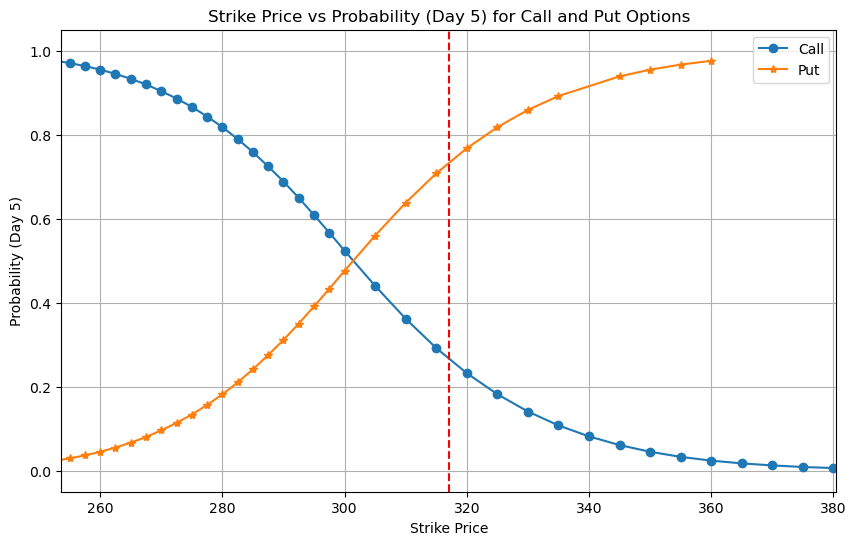

In [23]:
plot_strike_vs_probability(market_options,5)

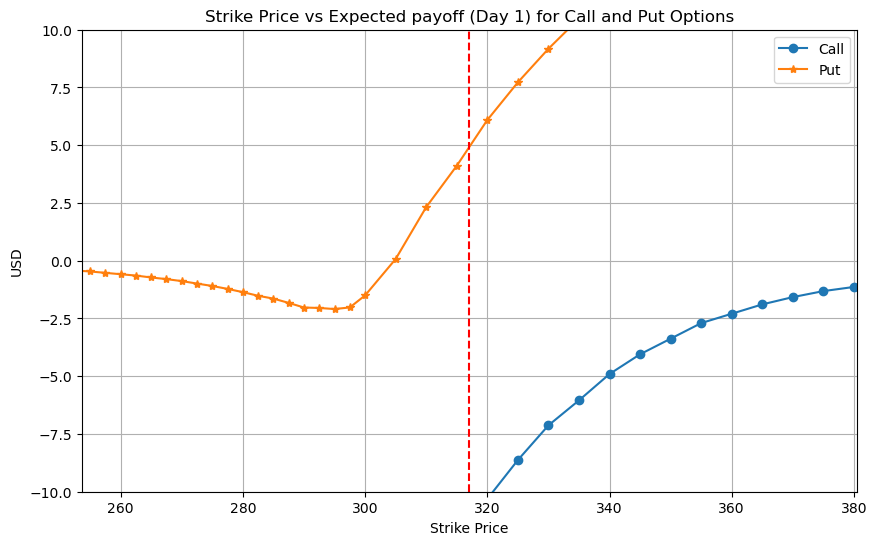

In [24]:
plot_strike_vs_payyoff(market_options,1)

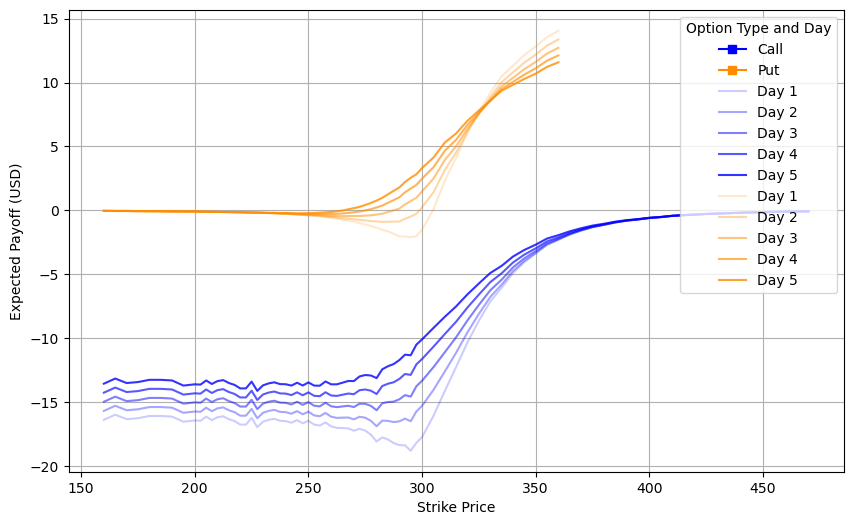

In [25]:
def plot_P_days(market_options):
    P_day_columns = [col for col in market_options.columns if col.startswith('expected payoff day ')]
    call_options = market_options[market_options['contractType'] == 'call']
    put_options = market_options[market_options['contractType'] == 'put']

    fig, ax = plt.subplots(figsize=(10, 6))

    n_days = len(P_day_columns)
    alphas = np.linspace(0.2, 0.8, n_days)

    call_color = 'blue'
    put_color = 'darkorange'
    
    for i, col in enumerate(P_day_columns):
        day_number = col.split(' ')[-1]
        ax.plot(call_options['strike'], call_options[col], label=f'Day {day_number}', 
                color=call_color, alpha=alphas[i])

    for i, col in enumerate(P_day_columns):
        day_number = col.split(' ')[-1]  # Extract day number from column name
        ax.plot(put_options['strike'], put_options[col], label=f'Day {day_number}', 
                color=put_color, alpha=alphas[i])

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=call_color, marker='s', label='Call'),
                    Line2D([0], [0], color=put_color, marker='s', label='Put')]
    
    ax.legend(handles=custom_lines + ax.get_legend_handles_labels()[0], title='Option Type and Day')

    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Expected Payoff (USD)')
    ax.grid(True)

    # Show the plot
    plt.show()
    
plot_P_days(market_options)